In [345]:
from os import listdir
from pandas import DataFrame, Series
from itertools import chain
from gensim.utils import tokenize
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
from numpy import isnan
from requests import get, exceptions
from itertools import chain
from nltk import sent_tokenize
import pymorphy2 
from nltk.stem.snowball import SnowballStemmer
import math
from textblob import TextBlob as tb
import pickle
from os import path, getcwd, makedirs
from operator import itemgetter
from collections import OrderedDict
from pylab import rcParams, savefig

Получение списка тредов доски

In [66]:
DVACH = 'https://2ch.hk/'
BOARD = 'me'

dvach_page = get(DVACH + BOARD + '/catalog.json').json()
threads = [i['num'] for i in dvach_page['threads']]

Формирование корпуса сообщений доски

In [69]:
documents = []

for every_thread in threads:
    try:
        thread = get(DVACH +  BOARD + '/res/' + every_thread + '.json', timeout=5).json()
        [documents.append(sent_tokenize(cut(i['comment']))) for i in thread['threads'][0]['posts'] if len(cut(i['comment'])) > 2]
    except:
        pass
   
documents = list(chain.from_iterable(documents))

Сериализация корпуса

In [70]:
subdir = 'pickle'
if not path.exists(subdir):
    makedirs(subdir)
file_path = path.join(subdir, BOARD + '.pickle')

with open(file_path, 'wb') as f:
    pickle.dump(documents, f)

Инициализация токенизатора

In [30]:
alpha_tokenizer = RegexpTokenizer('[A-Za-zА-Яа-я]\w+')
morph = pymorphy2.MorphAnalyzer()

def my_tokenize(sent):
    sents = list(alpha_tokenizer.tokenize(sent))
    return set([morph.parse(sent.lower())[0].normal_form for sent in sents if sent.lower() not in stop and len(sent.lower()) > 1])

model_data = [my_tokenize(sent) for sent in documents]

Инициализация стоп-слов

In [31]:
stop = stopwords.words('russian')
stop += stopwords.words('english')
my_stop = ['весь', 'всякий', 'тот', 'это', 'самое', 'каким', 'сама', 'никак', 'она', 'она', 'оно', 'какие', 'какого', 'которая', 'многое', 'чему', 'всему', 'раза', 'сразу', 'весь', 'раз', 'пор', 'например', 'вроде', 'которые', 'который', 'просто', 'очень', 'почему', 'вообще', 'ещё', 'типа', 'ради', 'всё', 'хотя', 'тебе', 'нужно', 'пока']
my_stop_verb = ['сделать', 'можешь', 'могу', 'могут', 'делать', 'будешь', 'быть', 'будут', 'смочь']
[stop.append(morph.parse(i)[0].normal_form) for i in my_stop]
[stop.append(morph.parse(i)[0].normal_form) for i in my_stop_verb]
dvach_stop = ['такое', 'лол', 'бля']
stop += dvach_stop

Word2vec модель

In [173]:
min_count = 1
size = 600
window = 40

model = Word2Vec(model_data, min_count=min_count, size=size, window=window,  workers=4)

In [175]:
model.most_similar(morph.parse('галера')[0].normal_form)

[('быть', 0.9999947547912598),
 ('стать', 0.9999947547912598),
 ('сидеть', 0.9999947547912598),
 ('думать', 0.999994695186615),
 ('такой', 0.9999945759773254),
 ('программист', 0.9999945759773254),
 ('человек', 0.9999945163726807),
 ('работа', 0.9999944567680359),
 ('уровень', 0.9999944567680359),
 ('взять', 0.9999944567680359)]

Регулярки

In [354]:
from re import sub, compile

def cut(data):
    r = compile(r'<.*?>|>>\d*|\(OP\)|&#(\d*);|&quot;|&gt;|(http|https):.*')
    return r.sub('', punctuate_word(punctuate_sent((data))))

def punctuate_sent(data):
    r = compile(r'([a-zA-Zа-яА-Я])([.!\?])')
    return r.sub(r'\1. ', data)

def punctuate_word(data):
    r = compile(r'([a-zA-Zа-яА-Я])([,])')
    return r.sub(r'\1, ', data)

def pos_cut(s):
    s = sub(r"ADJF", "ADJ", s)
    s = sub(r"ADVB", "ADV", s)
    s = sub(r"INFN", "VERB", s)
    return s

def topic_cut(word):
    return sub('[^a-zA-Zа-яА-Я]', '', word)

def check_for_rus_lan(word):
    regex = compile('[А-Яа-я]+$')
    if regex.match(word):
        return True
    return False

def check_dirty(word):
    regexp = compile(r'уеб|хуё|ёб|пидо|иби|хуй|еба|бля|еби|хуе|хуи|пиз|срал|velf|оеб')
    if regexp.search(word):
          return True
    return False

Объединение корпусов сообщений, обработка

In [141]:
texts = []
texts += pickle.load(open('pickle/pr.pickle', 'rb'))
texts += pickle.load(open('pickle/bo.pickle', 'rb'))
texts += pickle.load(open('pickle/me.pickle', 'rb'))
texts = [text.lower() for text in texts]

Составление словаря несловарных слов с ассоциированным каждому слову количества упоминаний этого слова в корпусе

In [266]:
words_dict = {}

for text in texts:
    for word in tokenize(text):
        if len(word) > 2 and not check_dirty(word) and str(morph.parse(word)[0].methods_stack[0][0]) == '<FakeDictionary>':
            if word not in words_dict:
                words_dict[word] = 0
            else:
                words_dict[word] += 1

Получение числа всех слов в тексте

In [318]:
lengths = [(len(list(tokenize(text)))) for text in texts]
words_amount = sum(lengths)

Создание датафрейма из словаря

In [351]:
df = DataFrame.from_dict(words_dict, orient='index').reset_index()
df.columns = ['word', 'frequency']
df = df.sort_values(by=['frequency', 'word'], ascending=False).reset_index()
percentage = []
for i in df.frequency:
    percentage.append(round(i/words_amount*100,4))
df['percentage'] = Series(percentage, index=df.index)
df

,index,word,frequency,percentage
0,6624,алсо,489,0.0257
1,17328,бамп,453,0.0238
2,22135,посоны,196,0.0103
3,12201,юзать,191,0.0100
4,7241,букач,180,0.0095
5,24269,двач,170,0.0089
6,2555,типо,157,0.0082
7,27916,айти,150,0.0079
8,9702,фреймворки,137,0.0072
9,8451,фреймворк,131,0.0069


Отрисовка графика

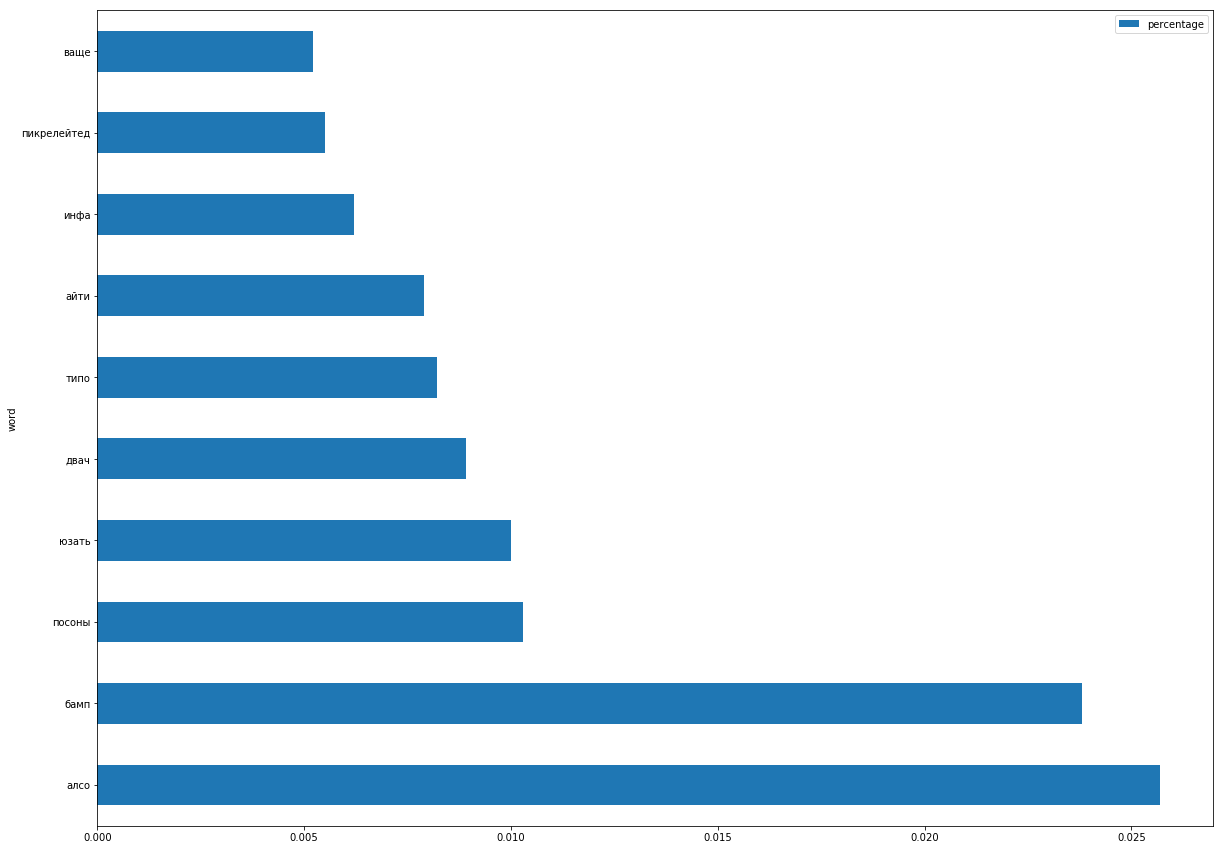

In [346]:
%matplotlib inline

rcParams['figure.figsize'] = 20, 15

df[:10].plot.barh(x='word', y='percentage')
savefig('plot.png')